In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import sys
import scipy.io
sys.path.append("..")
import ODE_Dynamics as od
import Test_Likelihood as tl
import Positive_Symptom_fn as fn

In [2]:
data = scipy.io.loadmat('../data/test_data_simulation.mat')
x = tf.cast(data['data_simulation'],dtype = tf.float32)
test_data = np.reshape(
      x, x.shape)

In [3]:
test_data = tf.transpose(test_data)

In [4]:
vdyn_ode_fn = od.ViralDynamics

In [5]:
positive_fn = fn.proba_pos_sym(170306.4 * 1E-5).positive_fn
symptom_fn = fn.proba_pos_sym(170306.4 * 1E-5).symptom_fn

In [6]:
prob_s_ibar = 0.1

In [7]:
loglike = tl.loglik(test_data, vdyn_ode_fn, positive_fn, symptom_fn, prob_s_ibar, prob_fp=0.0, Epi_Model=od.SIR,
                 duration= 20.0, Epi_cadence=0.5, Vir_cadence=0.0625)

In [8]:
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)
L = 0.0025/beta
V0 = np.random.normal(1E3, 1E2, 1)
print(V0)
X0 = 1E6
Y0 = V0
par=tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10, V0, X0, Y0]], dtype=np.float32))
vpar = par
pospar = par
sympar = par

[969.42979175]


In [9]:
sample_size = 1166
k = 1
index = 1
mu_b, sigma_b = 5, 1
beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
L = 0.0025/beta
par=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
V0 = np.random.normal(1E3, 1E2, 1)
X0 = 1E6
Y0 = V0
init_state=(np.array([[V0,X0,Y0]], dtype=np.float32))

while index <= sample_size - 1:
    beta = np.random.normal(mu_b, sigma_b, 1)   #"rate at which virus infects host cells"
    L = 0.0025/beta
    par_new=np.array([[L,0.01,beta*1E-7,0.5,20.0,10.0]])
    par = np.concatenate((par, par_new), axis = 0)
    V0 = np.random.normal(1E3, 1E2, 1)
    X0 = 1E6
    Y0 = V0
    init_state_new=(np.array([[V0,X0,Y0]], dtype=np.float32))
    init_state = np.concatenate((init_state, init_state_new), 0)

    index +=1
        

vpar = tf.constant(par, dtype=tf.float32)
pospar = par
sympar = par
print(par.shape)

(1166, 6)


In [10]:
epipar = tf.constant(np.array([[1.8,  5.0E-08,0.1, 0.001,0.999]], dtype=np.float32))

In [11]:
ll,pp = loglike.__call__(test_data,epipar, vpar, pospar, sympar)

initial time
0.0
final time
tf.Tensor(149.0, shape=(), dtype=float32)


In [12]:
C_xt = test_data[:,2]
N_xt = test_data[:,1]
pp_simu = C_xt/N_xt

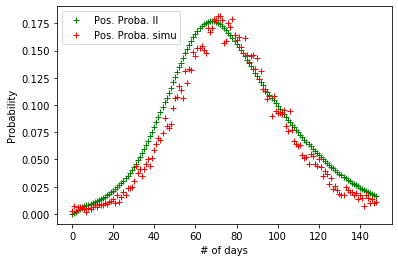

In [14]:
import matplotlib.pyplot as plt
plt.plot(test_data[:,0], pp,"g+", label = "Pos. Proba. ll")
plt.plot(test_data[:,0], pp_simu, "r+", label = "Pos. Proba. simu")
plt.xlabel("# of days")
plt.ylabel("Probability")
plt.legend(loc="upper left")
plt.savefig('simu_vs_code.png', dpi=300, bbox_inches='tight')